https://www.ast.cam.ac.uk/ioa/research/lensedquasars/

https://www.ast.cam.ac.uk/ioa/research/lensedquasars/lensedquasars.fits

In [14]:
%matplotlib inline

In [80]:
import matplotlib as mp
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
import astropy.units as u
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord 

import numpy as np

In [69]:
mp.rcParams['figure.figsize'] = (12, 8)

Read the fits file provides by the Gravitational Lensed Quasar database group.

In [50]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
hdul = fits.open("https://www.ast.cam.ac.uk/ioa/research/lensedquasars/lensedquasars.fits")

In [3]:
hdul.info()

/Users/abombrun/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/abombrun/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Filename: /Users/abombrun/.astropy/cache/download/py3/ea5d27b1eed553fd7f469282921c71a1
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     26   203R x 9C   [D, D, 17A, 11A, 6A, 5A, K, 13A, 13A]   


In [71]:
table = Table(hdul[1].data)
glqdb = table.to_pandas()

In [72]:
glqdb.columns

Index(['RA', 'DEC', 'Name', 'z_qso', 'z_lens', 'separation', 'N_images', 'W1',
       'W2'],
      dtype='object')

In [73]:
glqdb[['RA','DEC','Name']].to_csv("data/GLQdatabse.csv",index=False)

Text(0.5,1,'GLQ database')

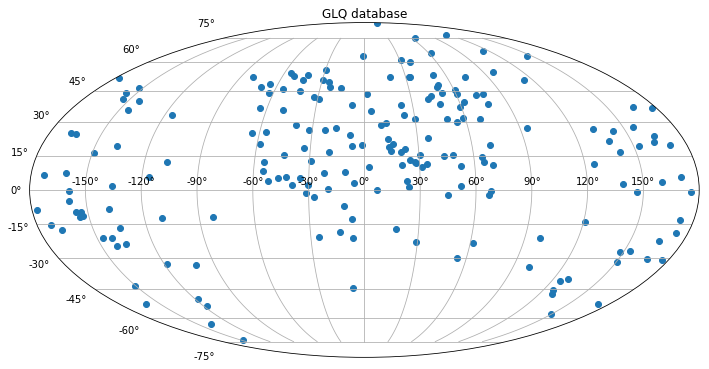

In [77]:
plt.figure(figsize=(12,10))
plt.subplot(111,projection="mollweide")
plt.scatter((glqdb.RA-180)*u.deg.to(u.rad),glqdb.DEC*u.deg.to(u.rad))
plt.grid()
plt.title("GLQ database")

In [75]:
ra = glqdb.RA[0]
dec = glqdb.DEC[0]
radius = 5*u.arcsecond.to(u.deg)

In [76]:
query = "select gaia.* from gaiadr2.gaia_source as gaia "
query += "where 1=contains( point('ICRS',%s ,%s), circle('ICRS', gaia.ra, gaia.dec, %s))"%(ra,dec,radius) 

In [47]:
query

"select gaia.* from gaiadr2.gaia_source as gaia where 1=contains( point('ICRS',2.83435 ,-8.7643), circle('ICRS', gaia.ra, gaia.dec, 0.001388888888888889))"

In [51]:
%time job = Gaia.launch_job_async(query, dump_to_file=False)

Query finished.
CPU times: user 46.1 ms, sys: 3.07 ms, total: 49.2 ms
Wall time: 2.24 s


In [53]:
job.get_data()

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url
,,,,yr,deg,mas,deg,mas,mas,mas,,mas.yr**-1,mas.yr**-1,mas.yr**-1,mas.yr**-1,,,,,,,,,,,,,,,,,mas,,,,mas**-2,um**-1,um**-1,,,,mas,,,,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,,mag,mag,mag,km.s**-1,km.s**-1,,K,log(cm.s**-2),'dex',,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,Rsun,Rsun,Rsun,Lsun,Lsun,Lsun,,
int64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,object,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,object,object
1635721458409799680,Gaia DR2 2429242023833003648,2429242023833003648,252935589,2015.5,2.834612302987248,1.0627376236450325,-8.764535938726787,0.6629196808553178,1.3276203674457565,1.2937156812593504,1.0262072,-3.195734600774424,1.82978586090491,-1.8684786969820137,1.1458379097435156,0.5290833,0.6451723,0.04215718,-0.20102653,0.42780805,-0.14432293,0.19444141,-0.2229397,-0.31513408,0.503866,185,0,184,1,2.2840064,225.00912,1.572039923173217,1.0625098917755667,31,False,0.03878695,1.0816603784439391,0.2059489885155355,-0.05345593,22,12,1.7364968,0,24,False,191,131.54686792718647,1.1215845776747242,117.28662,20.390665,9,189.15782455505632,15.186548770505071,12.455616,19.659327,10,185.05966198044766,10.484542694257927,17.650713,19.093641,2.8447464,0,0.5656853,-0.7313385,1.2970238,--,--,0,--,--,--,NOT_AVAILABLE,93.75829344806596,-69.33281400981036,359.0848365644589,-9.162917167943245,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,http://geadata.esac.esa.int/data-server/datalink/links?ID=2429242023833003648,--
1635721458409799680,Gaia DR2 2429242023835943040,2429242023835943040,105818852,2015.5,2.8343553870495515,0.9106957949447028,-8.764076020775706,0.6585750040775876,0.5288872843989058,1.0847749917232448,0.48755482,1.58443343618

In [62]:
url = 'http://vospace.esac.esa.int/vospace/sh/67cdf9ac225fa75d985983321a2dd3689bf8e89f?dl=1'
d5 = Table.read(url,format='votable').to_pandas()
d5.qso_name = d5.qso_name.str.decode('ascii')
print ("Total number of LQSO is {}".format(len(d5)))

Total number of LQSO is 359


In [157]:
def wrap180(x):
    """
    wrap longitudes defined on [0 360] degrees to radian defined on [-pi pi]
    why should I use the minus to get the LMC where I want?
    """
    return -Angle(x,unit=u.deg).wrap_at(180*u.deg).rad

def sigma2(ea,ed,c) : 
    """ the largest eigen value of the covariance matrix defined by
    ea : right ascention error
    ed : declination error
    c  : correlation
    """
    res = np.power(ea,2) + np.power(ed,2) 
    res = res + np.sqrt(np.power(ea-ed,2) + np.power(2*ea*ed*c,2))
    return res/2

def setMu(d):
    """
    set mu, mu_error and mu_norm taking in account the correlation
    """
    d['mu'] = np.sqrt(np.power(d.pmra,2)+np.power(d.pmdec,2))
    d['mu_error'] = np.sqrt(sigma2(d.pmra_error,d.pmdec_error,d.pmra_pmdec_corr))
    d['mu_over_error'] = d.mu/d.mu_error
    
parameters = ['x','y','dx','dy','xe','ye','dxe','dye','g','ge']

def getLQSO(d,name):
    """
    get the objects in the pandas dataframe d at an angular distance less than r arcsecond
    
    Since Gaia does not provide g mag error, I use quick approximation using the flux error... 
    maybe one should rather adapt the SIS code to use flux instead of magnitude
    
    d :  pandas data frame
    center : astropy skycoordinate
    r : radius in arcsecond
    """
    s = d[d.qso_name==name].copy()
    scale = u.deg.to(u.arcsecond)
    s['x'] = (s.ra - s.ra.median())*scale*np.cos(d.dec*u.deg.to(u.rad))
    s['y'] = (s.dec- s.dec.median())*scale
    
    s['xe']=s.ra_error*u.mas.to(u.arcsec)*np.cos(d.dec*u.deg.to(u.rad))
    s['ye']=s.dec_error*u.mas.to(u.arcsec)
    
    s['dx']= s.pmra
    s['dy']= s.pmdec
    s['dxe']=s.pmra_error
    s['dye']=s.pmdec_error
    s['g'] = s.phot_g_mean_mag
    s['ge'] = s.phot_g_mean_mag/s.phot_g_mean_flux_over_error
    return s


def plotGaiaLense(d,center,r=(-4,4),pm=True,title=""):
    """
    plot the position and the proper motion of the objects in the pandas dataframe d 
    at an angular distance of the center below 10 arcseconds
    d :  pandas data frame
    center : astropy skycoordinate
    r : plot x and y limits
    pm : to plot 
    """
    s = getLQSO(d,center)
    if(title=="") :
        title = center
    plotGaiaLense2(s,r=r,pm=pm,title=title)
    return s
    
def plotGaiaLense2(d,r=(-4,4),pm=True,title=""):
    """
    plot the position and the proper motion of the objects in the pandas dataframe d 
    at an angular distance of the center below 10 arcseconds
    position in arcsecond, proper motion and error bars in milli arcsecond
    d :  pandas data frame
    center : astropy skycoordinate
    r : plot x and y limits
    pm : to plot 
    """
    x = d.x
    y = d.y
    plt.errorbar(x,y,xerr=d.xe*1e3, yerr=d.ye*1e3,fmt='.')
    plt.scatter(x,y,s=100*np.exp(20-d.g),
                c=d.astrometric_pseudo_colour,vmin=1.2,vmax=2,cmap=mp.cm.coolwarm_r)
    plt.colorbar(label="astrometric pseudo color $[\mu m^{-1}]$")
    if pm : 
        vx = d.dx
        vy = d.dy
        plt.quiver(x,y, vx, vy, angles='xy', scale_units='xy', scale=1)
        plt.errorbar(x+vx,y+vy,xerr=d.dxe, yerr=d.dye,fmt='o')
    plt.grid()
    plt.xlabel("x [\"]")
    plt.ylabel("y [\"]")
    plt.title(title)
    plt.xlim(r[1],r[0])
    plt.ylim(r)

In [66]:
setMu(d5)

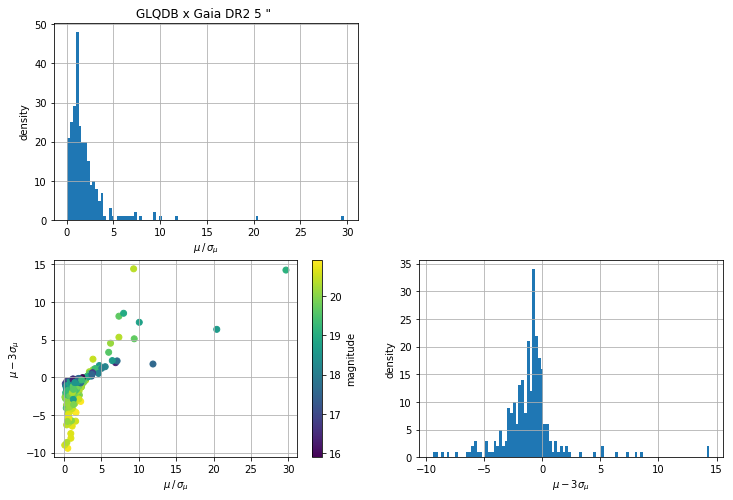

In [70]:
plt.subplot(221)
d5.mu_over_error.hist(bins=100)
plt.title("GLQDB x Gaia DR2 5 \" ")
plt.ylabel("density")
plt.xlabel("$\mu \, / \, \sigma_{\mu}$")

plt.subplot(224)
(d5.mu-3*d5.mu_error).hist(bins=100)
plt.ylabel("density")
plt.xlabel("$\mu - 3  \sigma_{\mu}$")

plt.subplot(223)
plt.scatter(d5.mu_over_error,(d5.mu-3*d5.mu_error),c=d5.phot_g_mean_mag)
plt.xlabel("$\mu \, / \, \sigma_{\mu}$")
plt.ylabel("$\mu - 3  \sigma_{\mu}$")
plt.colorbar(label="magnitude")
plt.grid()

In [78]:
d = d5

(0, 5)

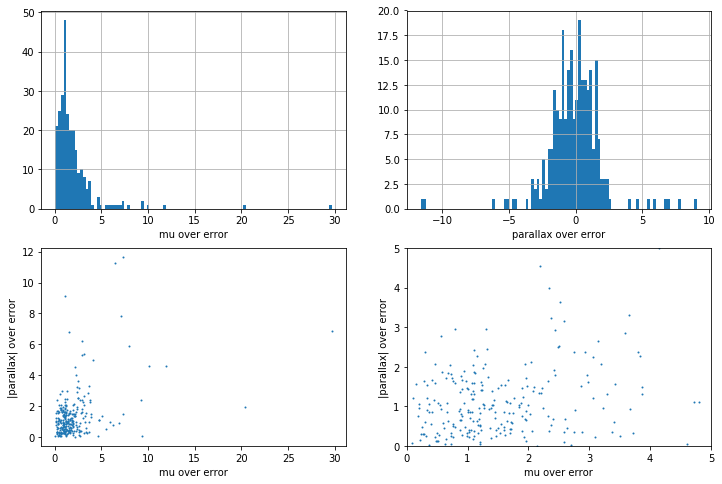

In [153]:
plt.subplot(221)
d.mu_over_error.hist(bins=100)
plt.xlabel("mu over error")

plt.subplot(222)
d.parallax_over_error.hist(bins=100)
plt.xlabel("parallax over error")

plt.subplot(223)
plt.scatter(d.mu_over_error,d.parallax_over_error.abs(),s=1)
plt.ylabel("|parallax| over error")
plt.xlabel("mu over error")

plt.subplot(224)
plt.scatter(d.mu_over_error,d.parallax_over_error.abs(),s=1)
plt.ylabel("|parallax| over error")
plt.xlabel("mu over error")
plt.xlim(0,5)
plt.ylim(0,5)

In [175]:
np.random.normal(len(d))

360.05462195547017

note that the proper motions and parallaxes are not independent

Text(0.5,0,'parallax over error')

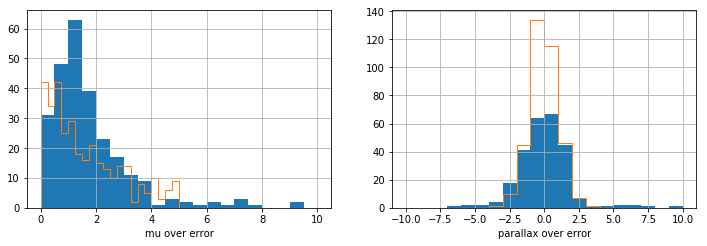

In [180]:
plt.subplot(221)
d.mu_over_error.hist(bins=20,range=(0,10))
plt.hist(np.random.chisquare(2,len(d)),bins=20,range=(0,5),histtype='step');
plt.xlabel("mu over error")

plt.subplot(222)
d.parallax_over_error.hist(bins=20,range=(-10,10))
plt.hist(np.random.normal(0,1,len(d)),bins=20,range=(-10,10),histtype='step');
plt.xlabel("parallax over error")

In [92]:
import seaborn as sns

No handles with labels found to put in legend.
No handles with labels found to put in legend.


(-2, 2)

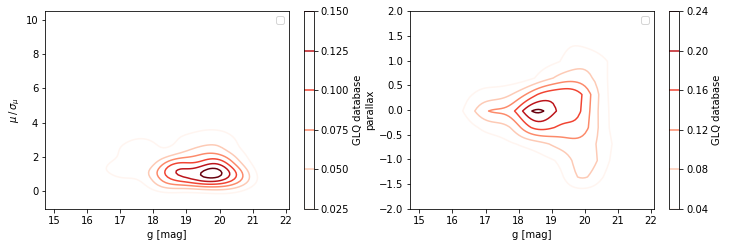

In [156]:
s = d5[(d5.mu_over_error<10) & (d5.parallax_over_error<10)]
plt.subplot(221)
sns.kdeplot(s.phot_g_mean_mag,s.mu_over_error,cmap="Reds",n_levels=6,cbar_kws={'label': 'GLQ database'},cbar=True)
plt.xlabel("g [mag]")
plt.ylabel("$\mu \, / \, \sigma_\mu$")
plt.legend()

plt.subplot(222)
sns.kdeplot(s.phot_g_mean_mag,s.parallax,cmap="Reds",n_levels=6,cbar_kws={'label': 'GLQ database'},cbar=True)
plt.xlabel("g [mag]")
plt.ylabel("parallax")
plt.legend()
plt.ylim(-2,2)

In [96]:
centers = d.groupby(d.qso_name)['ra','dec'].mean()
centers['coord'] = SkyCoord(centers.ra,centers.dec,unit='degree')
centers['mu_over_error'] = d.groupby(d.qso_name).mu_over_error.max()
centers = centers.reset_index()

In [97]:
len(centers)

168

In [98]:
len(centers[centers.mu_over_error>3])

37

select the QSO 

In [102]:
qso_names =  centers[centers.mu_over_error>3].qso_name.unique()

In [164]:
s = centers[centers.mu_over_error>3]

Text(0.5,1,'GLQ x DR2 [mu/mu_error > 3]')

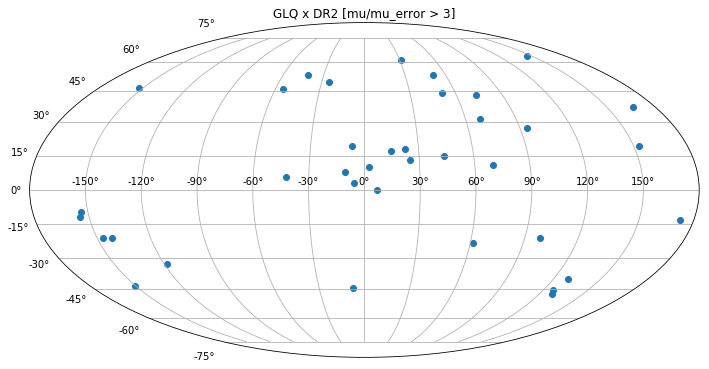

In [168]:
s = centers[centers.mu_over_error>3]
plt.figure(figsize=(12,10))
plt.subplot(111,projection="mollweide")
plt.scatter((s.ra-180)*u.deg.to(u.rad),s.dec*u.deg.to(u.rad))
plt.grid()
plt.title("GLQ x DR2 [mu/mu_error > 3]")

In [104]:
qso_names[0]

'DESJ0405-3308'

plot lensed QSOs as seen in Gaia DR2 :
* position in arcsecond
* proper motion and error bars in milli arcsecond
* color derived from astrometric pseudo color
* size derive from magnitude (bright sources are larger, faint sources smaller)

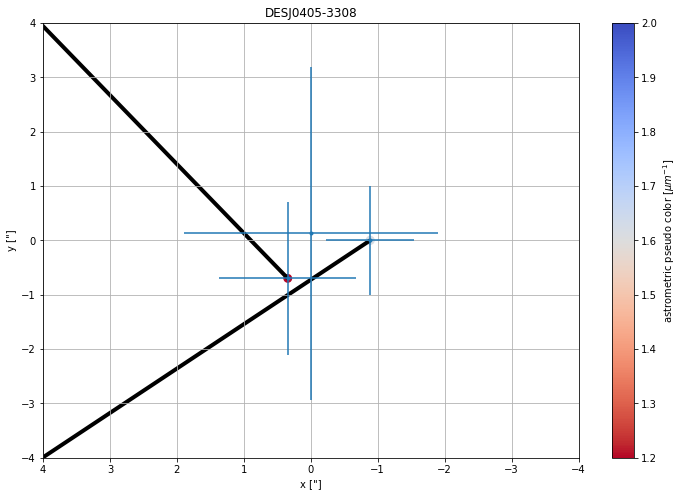

In [105]:
s = plotGaiaLense(d,qso_names[0])

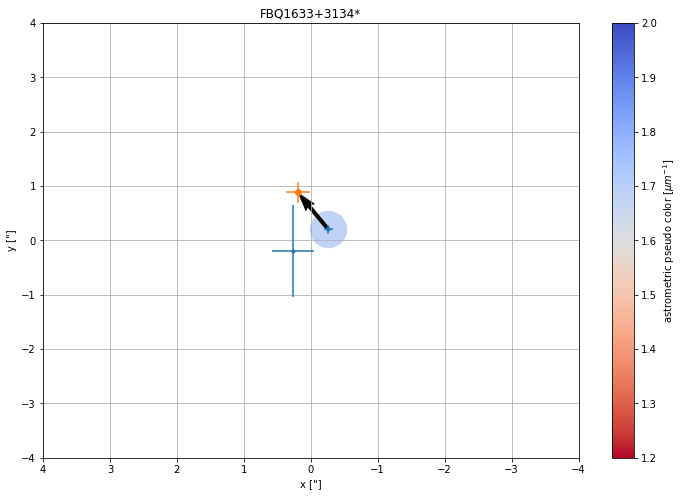

In [106]:
s = plotGaiaLense(d,qso_names[1])

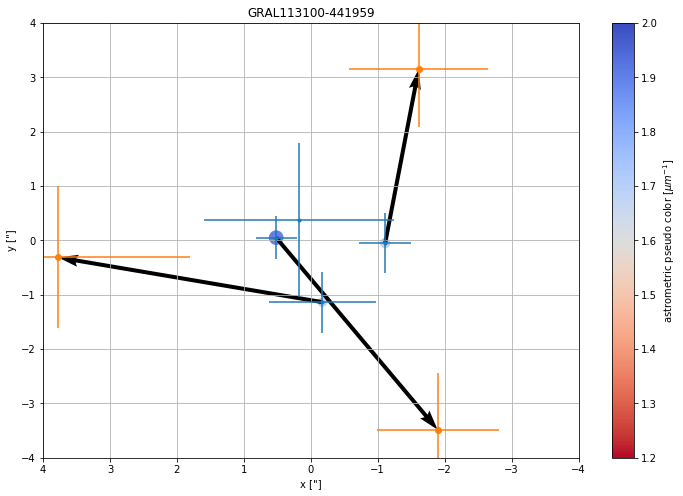

In [107]:
s = plotGaiaLense(d,qso_names[2])

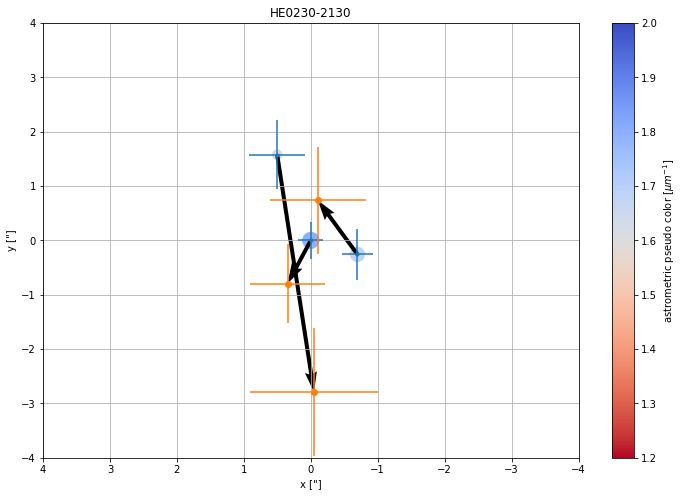

In [108]:
s = plotGaiaLense(d,qso_names[3])

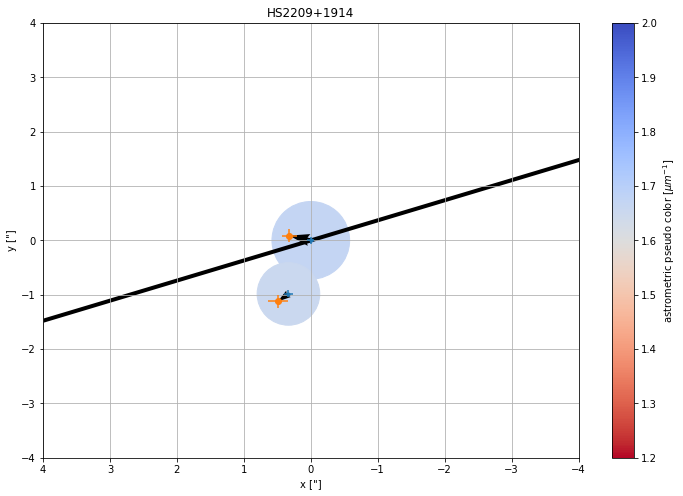

In [109]:
s = plotGaiaLense(d,qso_names[4])

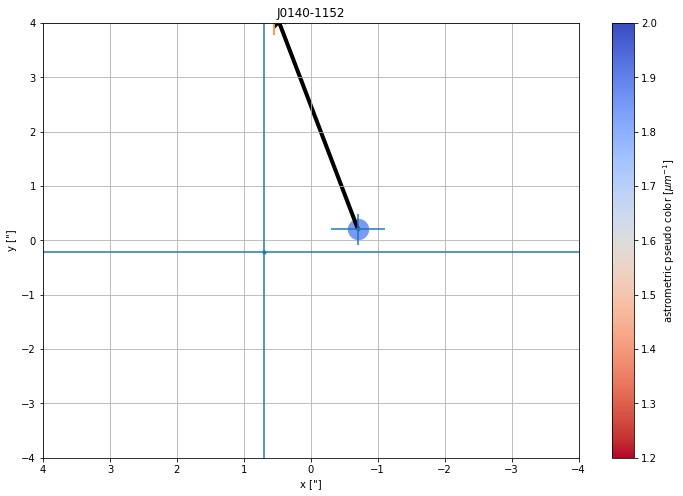

In [111]:
s = plotGaiaLense(d,qso_names[5])

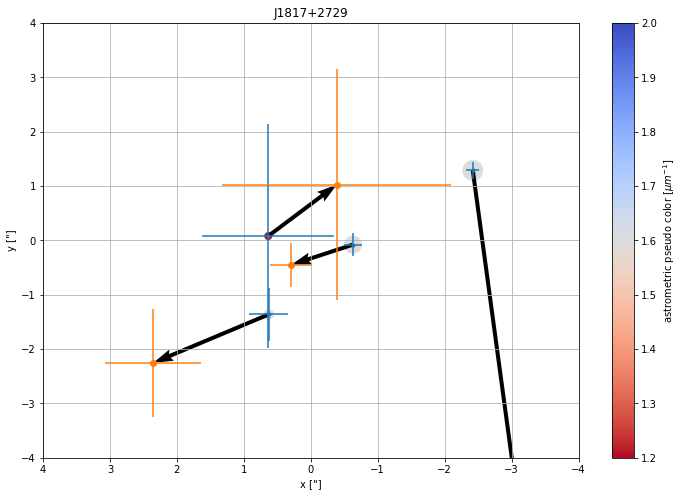

In [112]:
s = plotGaiaLense(d,qso_names[6])

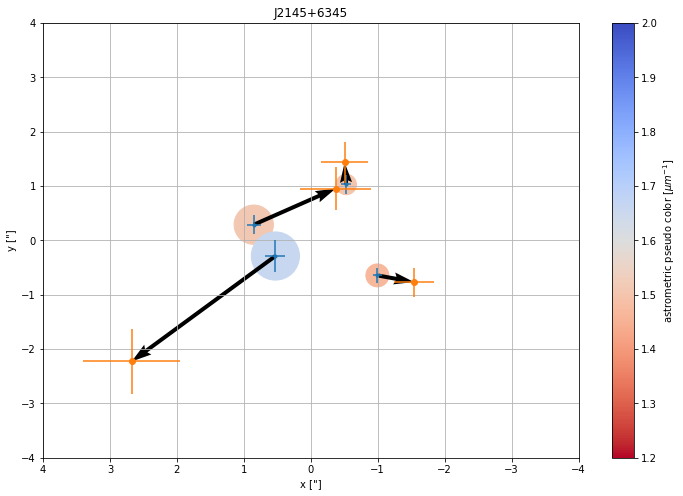

In [113]:
s = plotGaiaLense(d,qso_names[7])

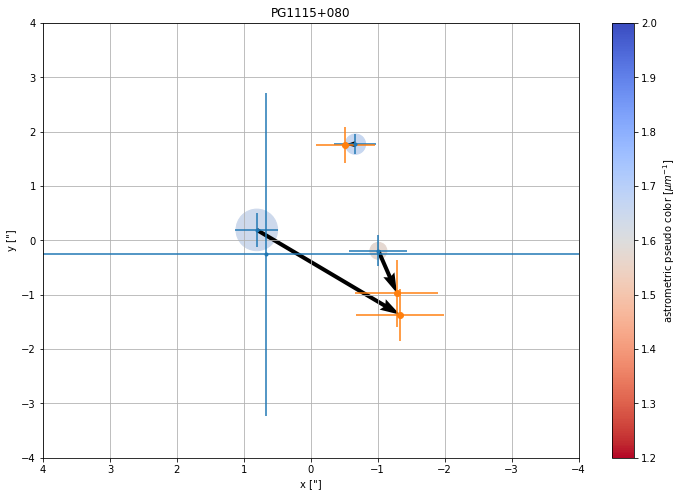

In [114]:
s = plotGaiaLense(d,qso_names[8])

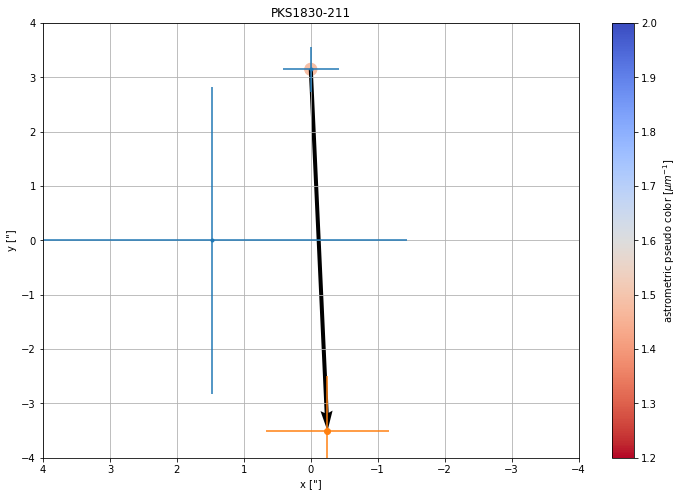

In [115]:
s = plotGaiaLense(d,qso_names[9])

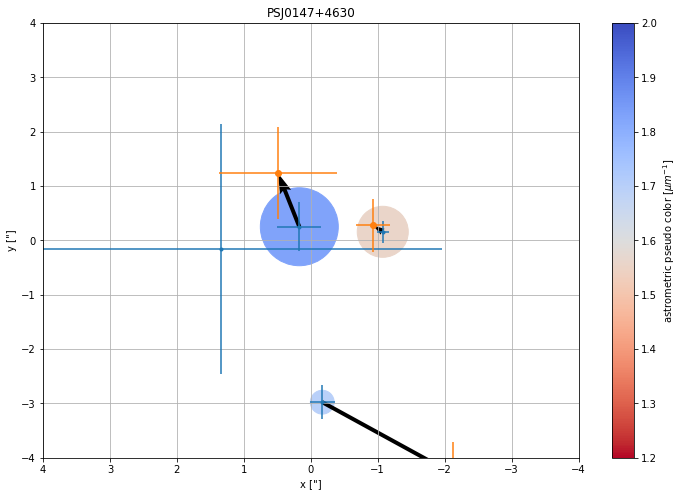

In [116]:
s = plotGaiaLense(d,qso_names[10])

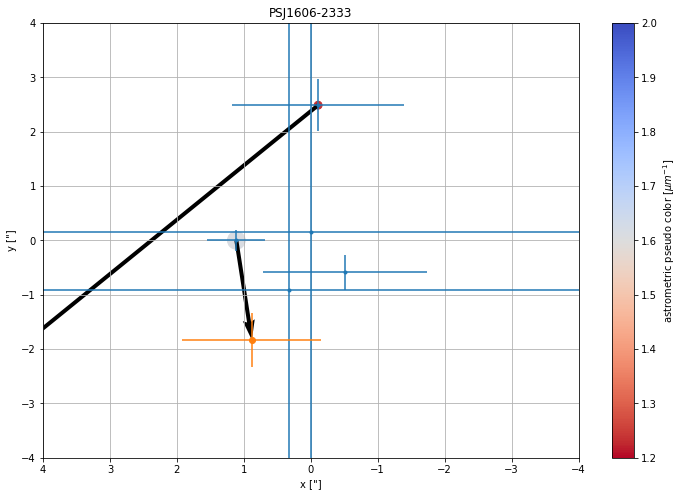

In [117]:
s = plotGaiaLense(d,qso_names[11])

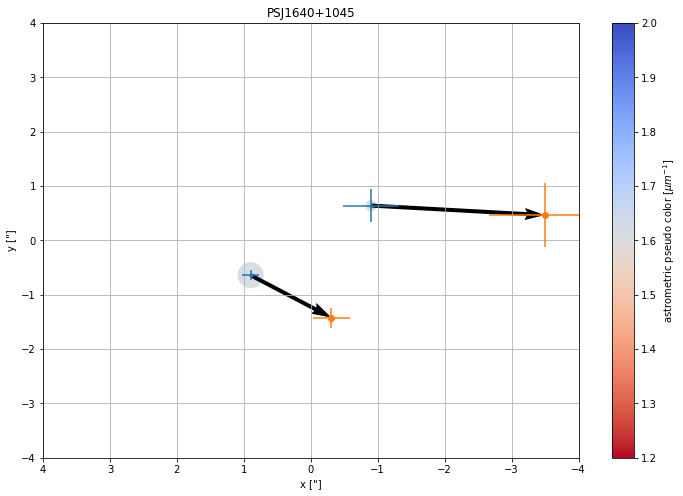

In [118]:
s = plotGaiaLense(d,qso_names[12])

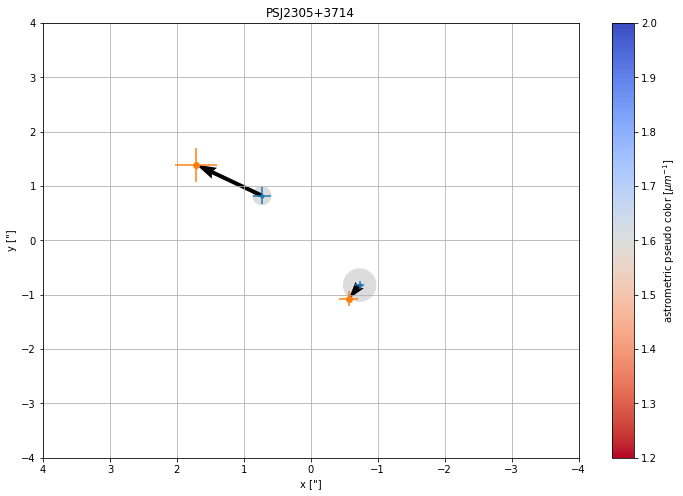

In [119]:
s = plotGaiaLense(d,qso_names[13])

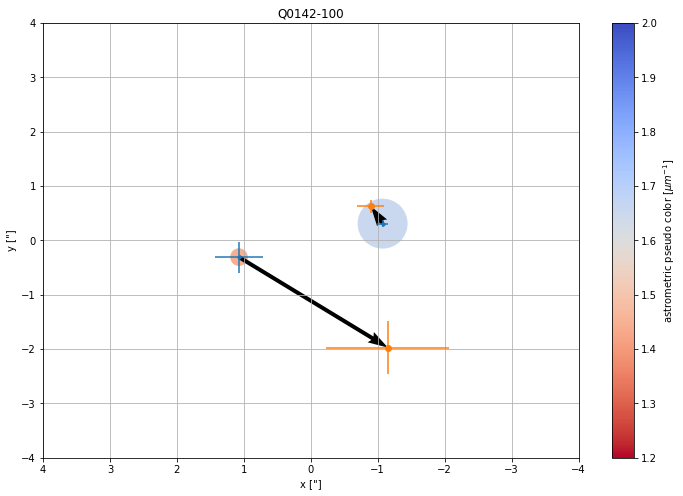

In [120]:
s = plotGaiaLense(d,qso_names[14])

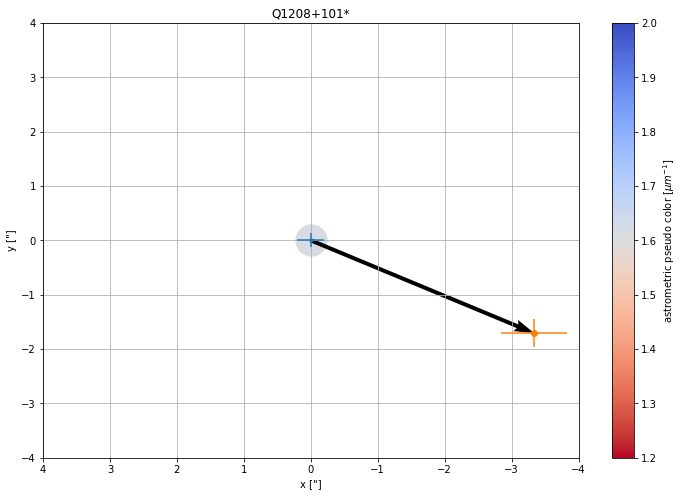

In [121]:
s = plotGaiaLense(d,qso_names[15])

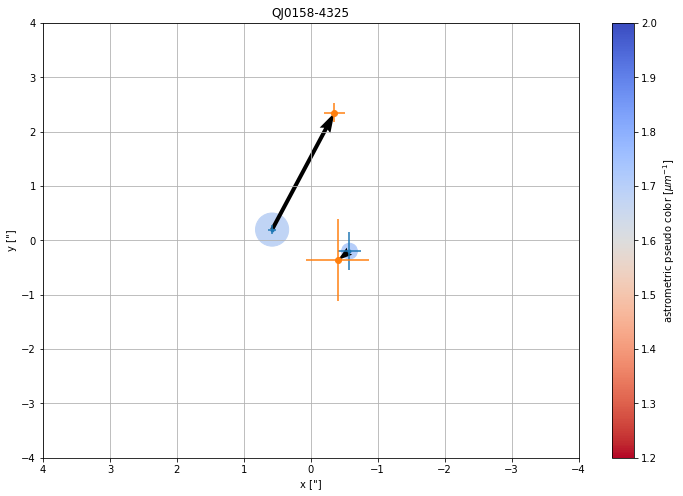

In [122]:
s = plotGaiaLense(d,qso_names[16])

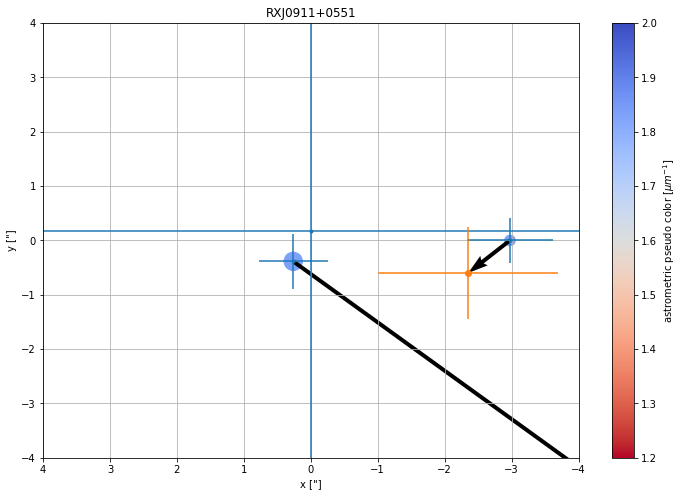

In [123]:
s = plotGaiaLense(d,qso_names[17])

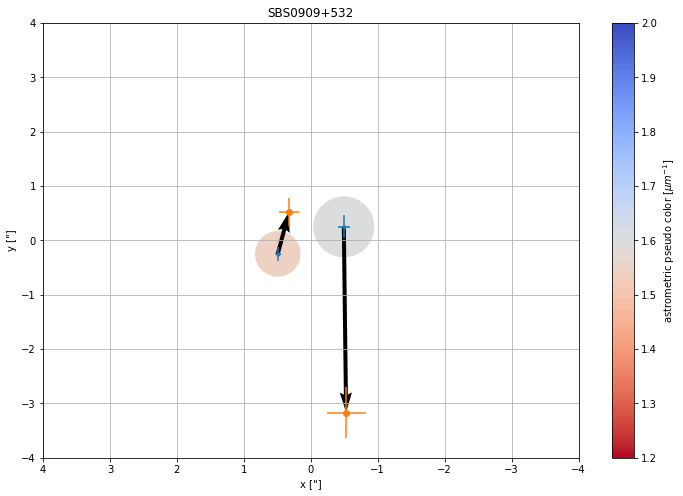

In [124]:
s = plotGaiaLense(d,qso_names[18])

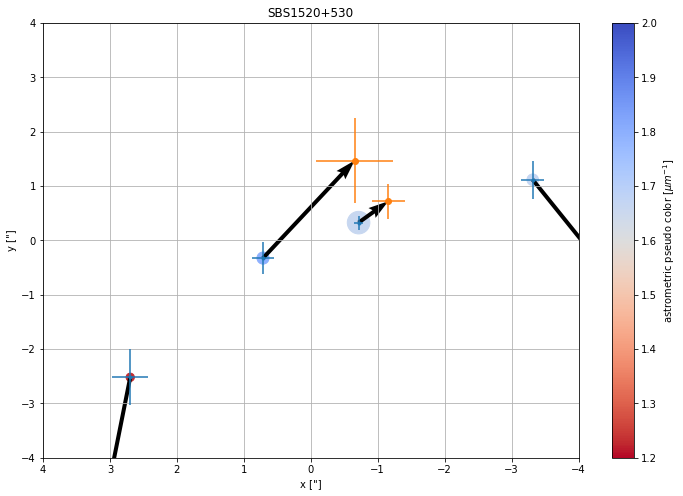

In [125]:
s = plotGaiaLense(d,qso_names[19])

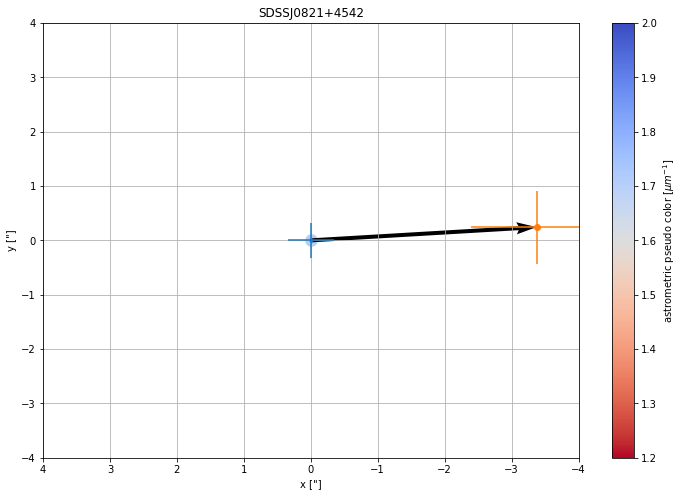

In [126]:
s = plotGaiaLense(d,qso_names[20])

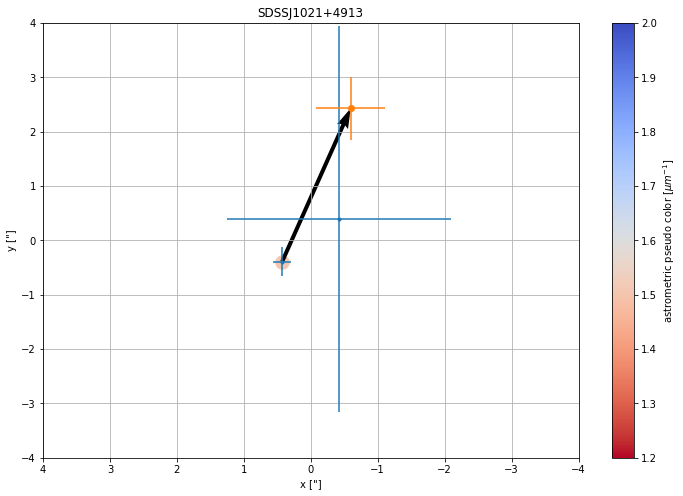

In [127]:
s = plotGaiaLense(d,qso_names[21])

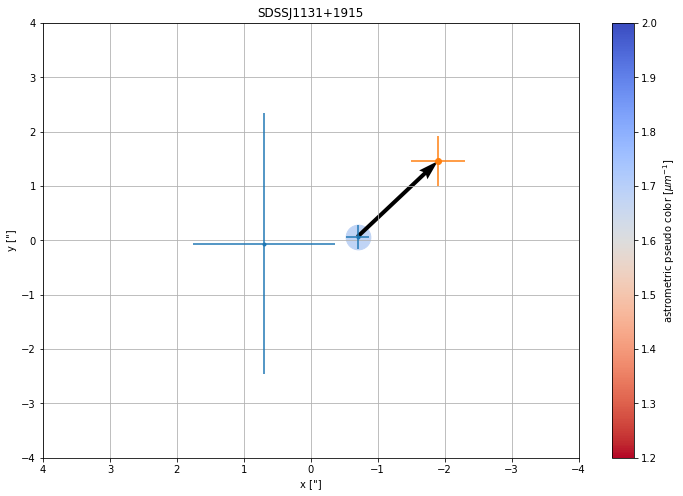

In [128]:
s = plotGaiaLense(d,qso_names[22])

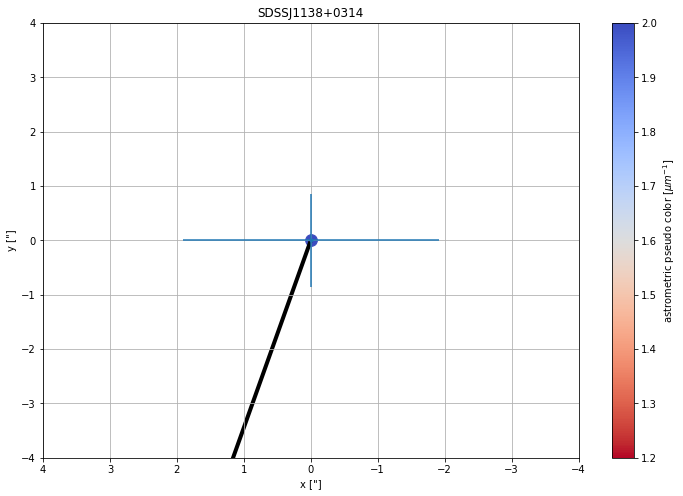

In [129]:
s = plotGaiaLense(d,qso_names[23])

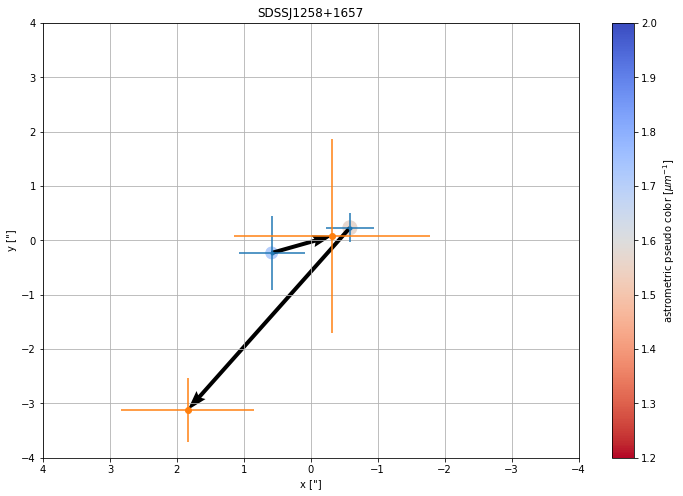

In [130]:
s = plotGaiaLense(d,qso_names[25])

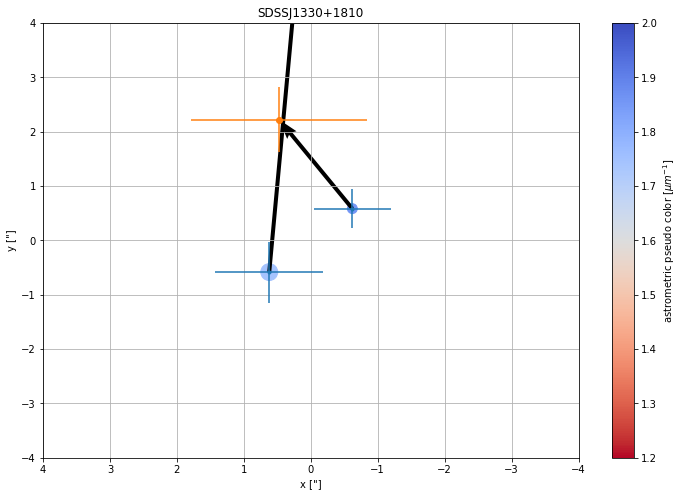

In [131]:
s = plotGaiaLense(d,qso_names[26])

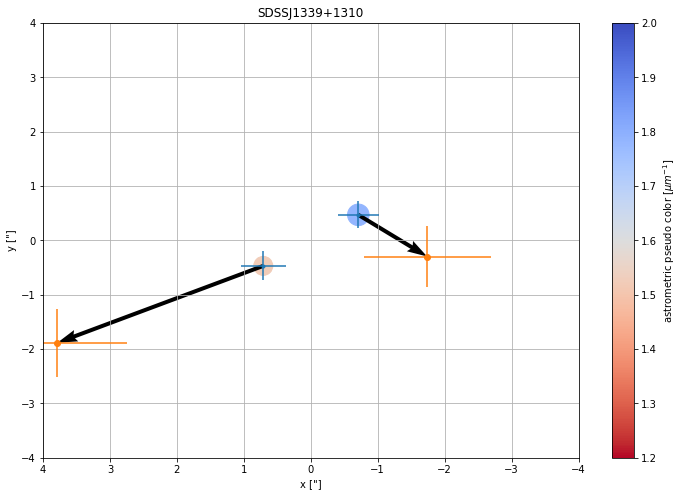

In [132]:
s = plotGaiaLense(d,qso_names[27])

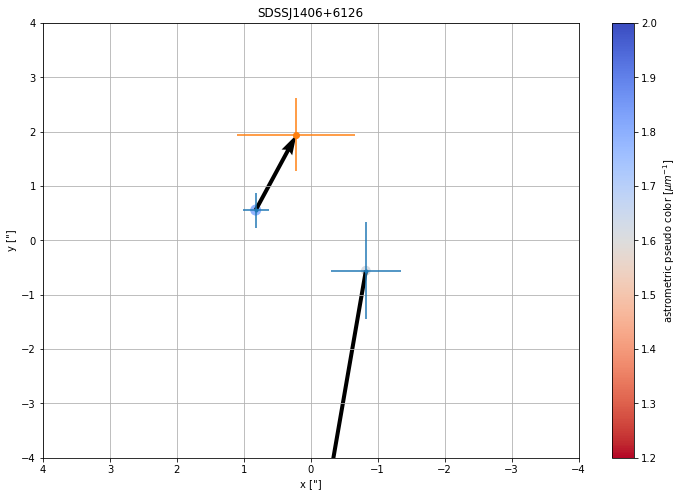

In [133]:
s = plotGaiaLense(d,qso_names[28])

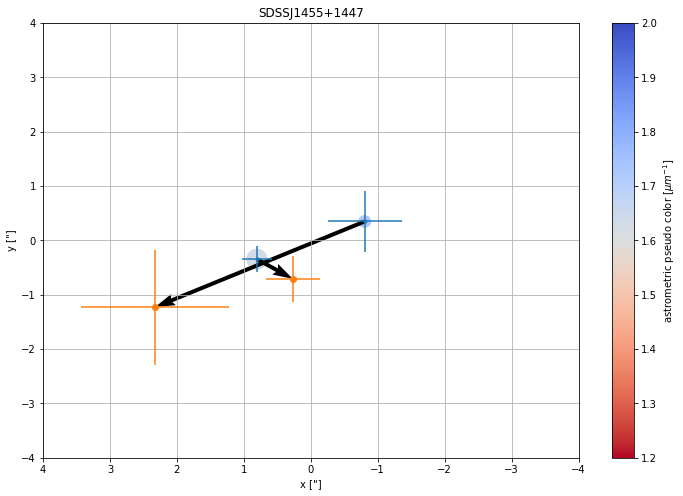

In [134]:
s = plotGaiaLense(d,qso_names[29])

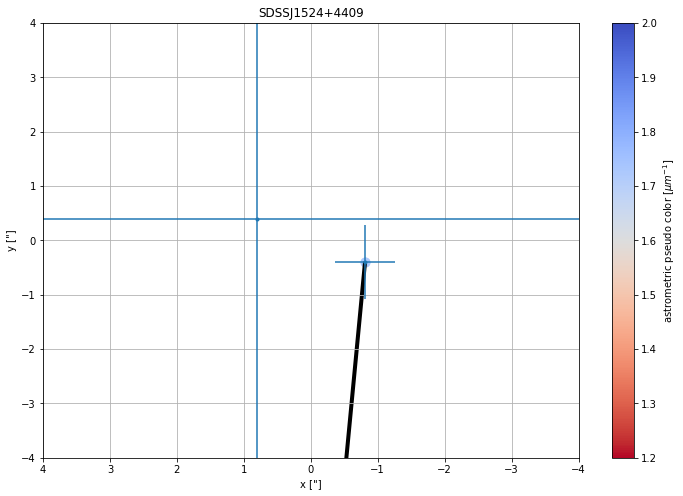

In [135]:
s = plotGaiaLense(d,qso_names[30])

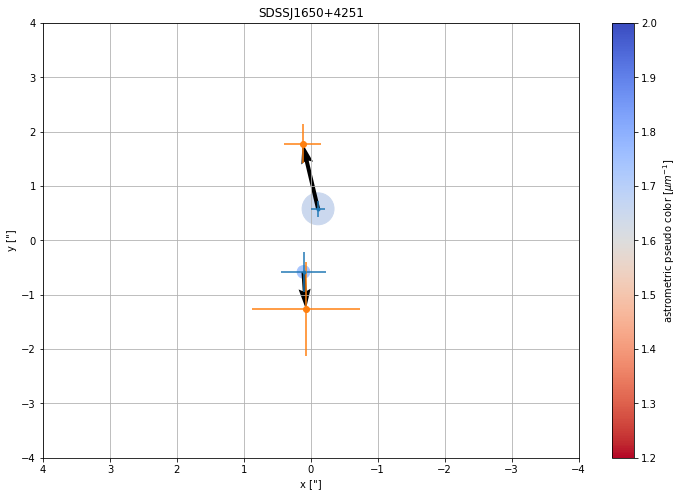

In [136]:
s = plotGaiaLense(d,qso_names[31])

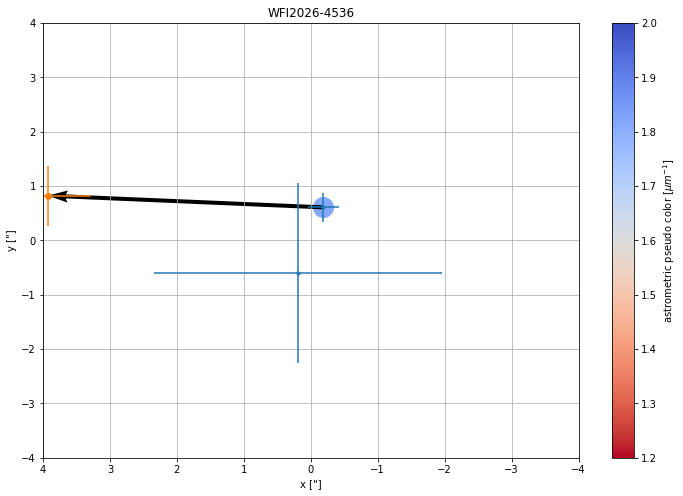

In [137]:
s = plotGaiaLense(d,qso_names[32])

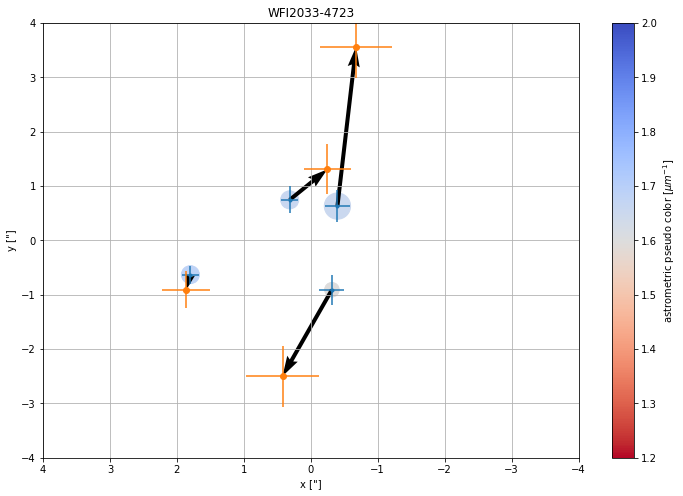

In [138]:
s = plotGaiaLense(d,qso_names[33])

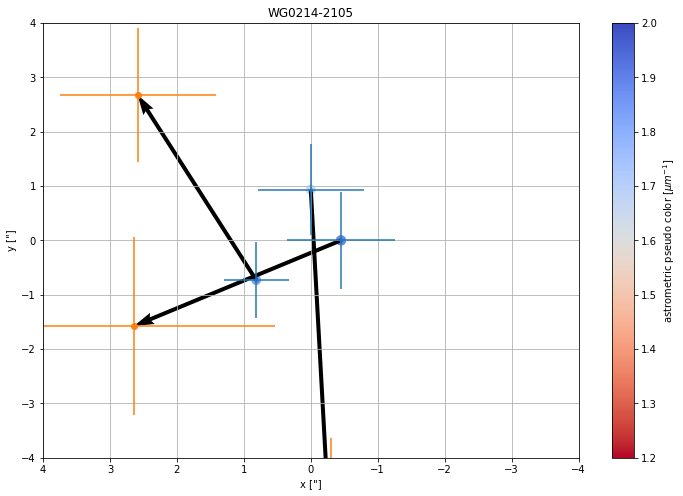

In [139]:
s = plotGaiaLense(d,qso_names[34])

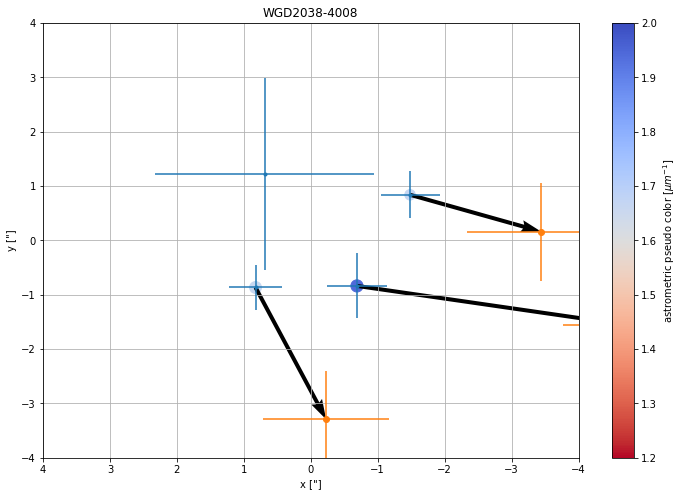

In [140]:
s = plotGaiaLense(d,qso_names[35])

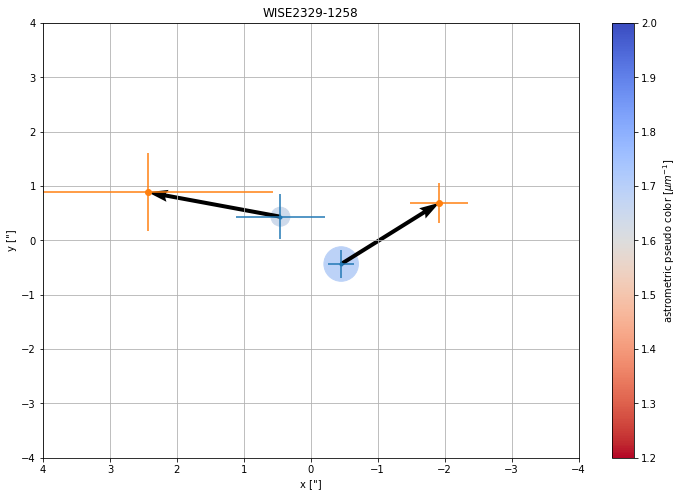

In [141]:
s = plotGaiaLense(d,qso_names[36])

In [159]:
qso_names[1]

'FBQ1633+3134*'

In [160]:
qso_names[32]

'WFI2026-4536'